In this notebook, we wil use tooks in the analytics engine to calculate HDDs on census tracts.

In [1]:
from climakitae.new_core.user_interface import ClimateData
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from climakitae.new_core.data_access.data_access import DataCatalog
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.tools.derived_variables import compute_hdd_cdd

cd = ClimateData()

catalog = DataCatalog()
census_tracts = catalog.boundaries._ca_census_tracts

#select an arbitraty sample of 10 census tracts
my_tracts = census_tracts.iloc[100:200]

2025-12-31 15:30:42 - climakitae.new_core.user_interface - INFO - Initializing ClimateData interface
2025-12-31 15:30:42 - climakitae.new_core.dataset_factory - INFO - DatasetFactory initialized with 3 validators and 10 processors
2025-12-31 15:30:42 - climakitae.new_core.user_interface - INFO - ClimateData initialization successful
2025-12-31 15:30:42 - climakitae.new_core.user_interface - INFO - ✅ Ready to query!


In [2]:
## basemap plotting magic from https://github.com/Eagle-Rock-Analytics/the-shoppe/blob/069d8cb3e4dae1bd4e2f23b282d3b17ced82d9ca/src/plotting.py

from urllib.request import Request, urlopen
import io
import cartopy.io.img_tiles as cimgt
from PIL import Image


def image_spoof_cached(tile_xyz: tuple, tile_url: str, desired_format: str):
    """
    Cached version of image_spoof. Uses tile XYZ, URL, and desired format as the cache key.
    """
    req = Request(tile_url)
    req.add_header("User-agent", "Anaconda 3")
    fh = urlopen(req)
    im_data = io.BytesIO(fh.read())
    fh.close()
    img = Image.open(im_data)
    img = img.convert(desired_format)
    return img

def image_spoof(self, tile):
    """
    This function reformats web requests from OSM for cartopy and caches them to avoid redownloading.
    """
    tile_url = self._image_url(tile)
    tile_key = (tile[0], tile[1], tile[2])  # tile = (z, x, y)
    img = image_spoof_cached(tile_key, tile_url, self.desired_tile_form)
    return img, self.tileextent(tile), "lower"

Text(0.5, 1.0, 'Sample Census Tracts')

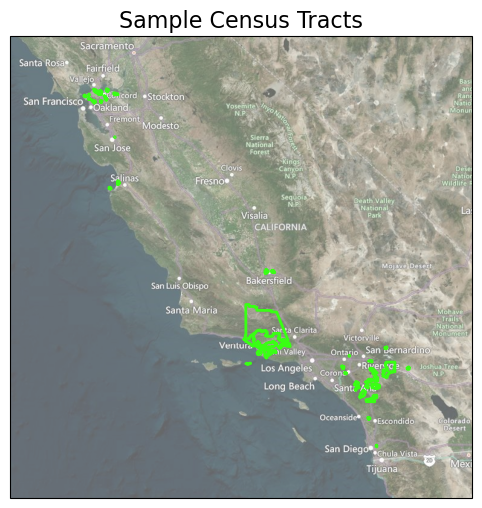

In [3]:
fig = plt.figure(figsize=(8, 6))

basemap_style = "satellite"  # options: "map", "satellite", None

if basemap_style == "map":
    cimgt.OSM.get_image = image_spoof
    tiler = cimgt.OSM()
elif basemap_style == "satellite":
    cimgt.QuadtreeTiles.get_image = image_spoof
    tiler = cimgt.QuadtreeTiles()
else:
    tiler = None

ax = fig.add_subplot(111, projection=tiler.crs)

if tiler:
    #ax = fig.add_subplot(1, projection=tiler.crs)  # Create subplot with map projection
    center_lon = -110
    center_lat = 33
    ax.add_image(tiler, 7, zorder=2, alpha=0.6)


# Superimpose census tract boundaries
my_tracts.boundary.plot(
    ax=ax,
    edgecolor='#39FF14',
    linewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=5)


plt.title("Sample Census Tracts", fontsize=16)


In [ ]:
tracts_wrf = (cd.catalog("cadcat")
        .activity_id("WRF")
        .variable("t2")
        .table_id("day")
        .grid_label("d03")
        .processes(
            {
                "warming_level": {
                    "warming_levels": [0.8,1.49,1.94],
                },
                "clip": {"boundaries": list(my_tracts['GEOID'].values), "separated": True},
                "convert_units": "degF"
            }
        )
        .get()
    )

2025-12-31 15:32:11 - climakitae.new_core.user_interface - INFO - Catalog set to: cadcat
2025-12-31 15:32:11 - climakitae.new_core.user_interface - INFO - Activity ID set to: WRF
2025-12-31 15:32:11 - climakitae.new_core.user_interface - INFO - Variable set to: t2
2025-12-31 15:32:11 - climakitae.new_core.user_interface - INFO - Table ID set to: day
2025-12-31 15:32:11 - climakitae.new_core.user_interface - INFO - Grid label set to: d03
2025-12-31 15:32:11 - climakitae.new_core.user_interface - INFO - Processes set: 3 operations configured
2025-12-31 15:32:11 - climakitae.new_core.user_interface - INFO - Starting data retrieval with query: {'catalog': 'cadcat', 'installation': UNSET, 'activity_id': 'WRF', 'institution_id': UNSET, 'source_id': UNSET, 'experiment_id': UNSET, 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 't2', 'station_id': UNSET, 'network_id': UNSET, 'processes': {'warming_level': {'warming_levels': [0.8, 1.49, 1.94]}, 'clip': {'boundaries': ['06029000504', '060

In [ ]:
tracts_wrf

<xarray.Dataset> Size: 147MB
Dimensions:            (census_tract: 4, sim: 5, warming_level: 3,
                        time_delta: 10950, y: 7, x: 8)
Coordinates: (12/13)
  * warming_level      (warming_level) float64 24B 0.8 1.49 1.94
  * x                  (x) float64 64B -4.119e+06 -4.116e+06 ... -4.089e+06
  * y                  (y) float64 56B 6.559e+05 6.589e+05 ... 7.129e+05
  * time_delta         (time_delta) int64 88kB -5475 -5474 -5473 ... 5473 5474
  * sim                (sim) object 40B 'WRF_UCLA_EC-Earth3_ssp370_day_d03_r1...
    lakemask           (census_tract, y, x) float32 896B dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    ...                 ...
    lat                (census_tract, y, x) float32 896B dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    lon                (census_tract, y, x) float32 896B dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    simulation         <U42 168B 'WRF.UCLA.EC-Earth3.ssp370.day.d03.r1i1p1f1'
    centered_year      (warming_level) int64 24B 2003 2034 2046
    Lambert_Conformal  int64 8B 0
  * census_tract       (census_tract) <U11 176B '06073021900' ... '06073013421'
Data variables:
    t2                 (census_tract, sim, warming_level, time_delta, y, x) float32 147MB dask.array<chunksize=(1, 1, 1, 3546, 2, 2), meta=np.ndarray>
Attributes: (12/121)
    AERCU_FCT:                        1.0
    AERCU_OPT:                        0
    AUTO_LEVELS_OPT:                  2
    BL_PBL_PHYSICS:                   1
    BOTTOM-TOP_GRID_DIMENSION:        40
    BOTTOM-TOP_PATCH_END_STAG:        40
    ...                               ...
    clip:                             Process 'clip' applied to the data. Sep...
    convert_units:                    Process 'convert_units' applied to the ...
    update_attributes:                Process 'update_attributes' applied to ...
    filter_unadjusted_models:         yes
    concat:                           Process 'concat' applied to the data. T...
    warming_level_simple:             Process 'warming_level_simple' applied ...

In [ ]:
tract_median = tracts_wrf.median(['x','y']).t2
#rename so this works nicely with the cdd/hdd function
tract_median = tract_median.rename("Air Temperature at 2m")
hdd, cdd = compute_hdd_cdd(tract_median, cdd_threshold=65, hdd_threshold=65) # Set for all data within selected DFZ zone

In [ ]:
#hdd = hdd.compute()
#cdd = cdd.compute()

In [ ]:
# calculate annual average total cdd/hdd
hdd_annual = add_dummy_time_to_wl(hdd).squeeze().groupby("time.year").sum(["time"]).mean('year')
cdd_annual = add_dummy_time_to_wl(cdd).squeeze().groupby("time.year").sum(["time"]).mean('year')

In [ ]:
hdd_annual = hdd_annual.compute()
cdd_annual = cdd_annual.compute()

In [26]:
# select only four models, excluding EC-Earth3-Veg with missing reference warming level
hdd_annual = cdd_annual.sel(sim = ['WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_TaiESM1_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_EC-Earth3_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_MPI-ESM1-2-HR_ssp370_day_d03_r3i1p1f1'])

cdd_annual = cdd_annual.sel(sim = ['WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_TaiESM1_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_EC-Earth3_ssp370_day_d03_r1i1p1f1',
       'WRF_UCLA_MPI-ESM1-2-HR_ssp370_day_d03_r3i1p1f1'])

In [27]:
cdd_annual_mmmean = cdd_annual.mean('sim')
hdd_annual_mmmean = hdd_annual.mean('sim')

In [28]:
# transform into dataframe for export
cdd_df = cdd_annual.to_dataframe()

In [29]:
cdd_df = cdd_df.reset_index()

In [25]:
cdd_annual.to_dataframe().to_csv("test.csv")

In [34]:
pivot_df = cdd_df.pivot(
            index='census_tract', 
            columns=['warming_level', 'sim'], 
            values='Cooling Degree Days'
        )

# Sort columns so all columns from each warming level are grouped together
pivot_df = pivot_df.sort_index(axis=1, level=[0, 1])

# Add multi-model mean columns for each warming level
for wl in pivot_df.columns.get_level_values(0).unique():
    # Calculate mean across all simulations for this warming level
    wl_cols = pivot_df.loc[:, wl]
    multi_model_mean = wl_cols.mean(axis=1)
    
    # Add as a new column with 'Multi-Model Mean' as the sim name
    pivot_df[(wl, 'Multi-Model Mean')] = multi_model_mean

# Re-sort to keep multi-model mean with its warming level group
pivot_df = pivot_df.sort_index(axis=1, level=[0, 1])

In [35]:
pivot_df

warming_level             0.80                                             \
sim           Multi-Model Mean WRF_UCLA_EC-Earth3_ssp370_day_d03_r1i1p1f1   
census_tract                                                                
06073013421         768.291260                                 904.463318   
06073020026         857.746948                                 978.172119   
06073020028        1055.020264                                1179.785034   
06073021900         585.070129                                 730.874390   

warming_level                                          \
sim           WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p1f1   
census_tract                                            
06073013421                                598.716797   
06073020026                                694.075806   
06073020028                                881.338745   
06073021900                                426.535065   

warming_level                                                 \
sim           WRF_UCLA_MPI-ESM1-2-HR_ssp370_day_d03_r3i1p1f1   
census_tract                                                   
06073013421                                       786.462646   
06073020026                                       864.609131   
06073020028                                      1059.342163   
06073021900                                       597.366516   

warming_level                                                      1.49  \
sim           WRF_UCLA_TaiESM1_ssp370_day_d03_r1i1p1f1 Multi-Model Mean   
census_tract                                                              
06073013421                                 783.522278      1150.063354   
06073020026                                 894.130737      1255.998047   
06073020028                                1099.615479      1488.625732   
06073021900                                 585.504639       920.176941   

warming_level                                             \
sim           WRF_UCLA_EC-Earth3_ssp370_day_d03_r1i1p1f1   
census_tract                                               
06073013421                                  1252.483887   
06073020026                                  1348.637207   
06073020028                                  1574.402588   
06073021900                                  1037.177734   

warming_level                                          \
sim           WRF_UCLA_MIROC6_ssp370_day_d03_r1i1p1f1   
census_tract                                            
06073013421                               1062.661255   
06073020026                               1169.804077   
06073020028                               1396.597412   
06073021900                                832.821411   

warming_level                                                 \
sim           WRF_UCLA_MPI-ESM1-2-HR_ssp370_day_d03_r3i1p1f1   
census_tract                                                   
06073013421                                      1263.363892   
06073020026                                      1358.455078   
06073020028                                      1597.510620   
06073021900                                      1017.250305   

warming_level                                                      1.94  \
sim           WRF_UCLA_TaiESM1_ssp370_day_d03_r1i1p1f1 Multi-Model Mean   
census_tract                                                              
06073013421                                1021.744812      1307.730835   
06073020026                                1147.095703      1410.552246   
06073020028                                1385.992188      1649.721558   
06073021900                                 793.458252      1064.400269   

warming_level                                             \
sim           WRF_UCLA_EC-Earth3_ssp370_day_d03_r1i1p1f1   
census_tract                                               
06073013421                                  1355.761353   
06073020026                                  1454

In [39]:
# Calculate percent change relative to 0.8°C warming level using multi-model mean
reference_wl = 0.8
reference_values = pivot_df[(reference_wl, 'Multi-Model Mean')]

# Create a new dataframe for percent changes
percent_change_df = pd.DataFrame(index=pivot_df.index)
percent_change_df['Reference (GWL 0.8°C)'] = reference_values

# Calculate percent change for each warming level
for wl in pivot_df.columns.get_level_values(0).unique():
    if wl != reference_wl:
        current_values = pivot_df[(wl, 'Multi-Model Mean')]
        percent_change = ((current_values - reference_values) / reference_values) * 100
        percent_change_df[f'% Change (GWL {wl}°C)'] = percent_change

print("Percent Change in Annual CDD Relative to GWL 0.8°C (Multi-Model Mean)")
print("="*80)
percent_change_df

Percent Change in Annual CDD Relative to GWL 0.8°C (Multi-Model Mean)


,Reference (GWL 0.8°C),% Change (GWL 1.49°C),% Change (GWL 1.94°C)
census_tract,,,
06073013421,768.291260,49.691063,70.212898
06073020026,857.746948,46.429905,64.448532
06073020028,1055.020264,41.099255,56.368710
06073021900,585.070129,57.276352,81.926956


In [ ]:
pivot_df.to_csv("sample_census_tract_data.csv")

In [ ]:
percent_change_df.to_csv("sample_census_tract_percent_change.csv")

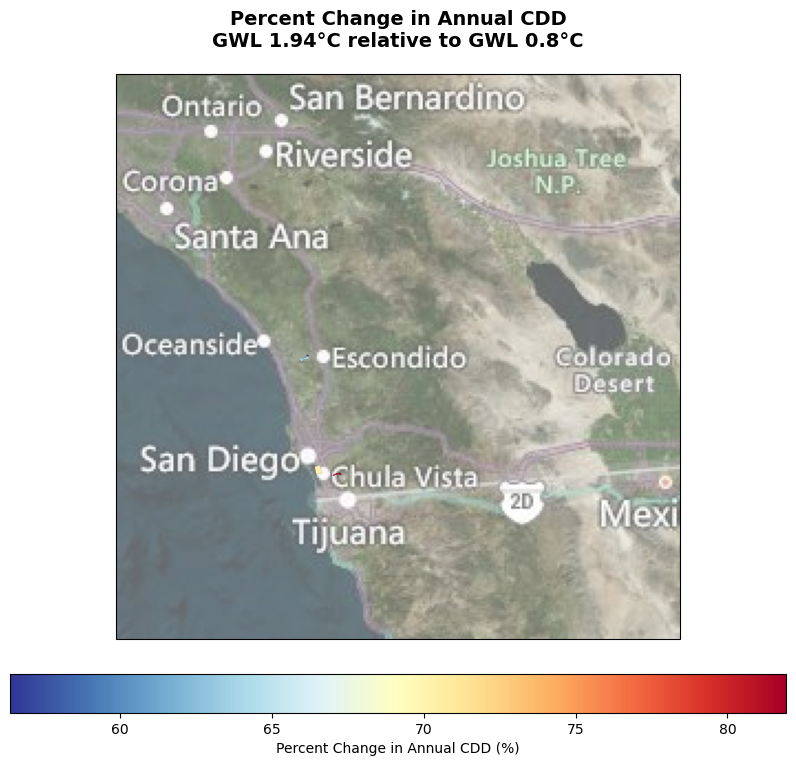

In [41]:
# Create a map showing percent change at 1.94°C warming level
fig = plt.figure(figsize=(10, 8))

basemap_style = "satellite"  # options: "map", "satellite", None

if basemap_style == "map":
    cimgt.OSM.get_image = image_spoof
    tiler = cimgt.OSM()
elif basemap_style == "satellite":
    cimgt.QuadtreeTiles.get_image = image_spoof
    tiler = cimgt.QuadtreeTiles()
else:
    tiler = None

ax = fig.add_subplot(111, projection=tiler.crs)

if tiler:
    center_lon = -110
    center_lat = 33
    ax.add_image(tiler, 7, zorder=2, alpha=0.6)

# Merge percent change data with census tract geometries
my_tracts_with_data = my_tracts.copy()
my_tracts_with_data['percent_change'] = percent_change_df['% Change (GWL 1.94°C)'].values

# Plot filled census tracts with color based on percent change
my_tracts_with_data.plot(
    ax=ax,
    column='percent_change',
    cmap='RdYlBu_r',  # Red for high increase, blue for low increase
    edgecolor='black',
    linewidth=0.05,
    transform=ccrs.PlateCarree(),
    legend=True,
    legend_kwds={'label': 'Percent Change in Annual CDD (%)', 
                 'orientation': 'horizontal',
                 'pad': 0.05,
                 'shrink': 0.8},
    alpha=1,
    zorder=5
)

plt.title(f"Percent Change in Annual CDD\nGWL 1.94°C relative to GWL 0.8°C", 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

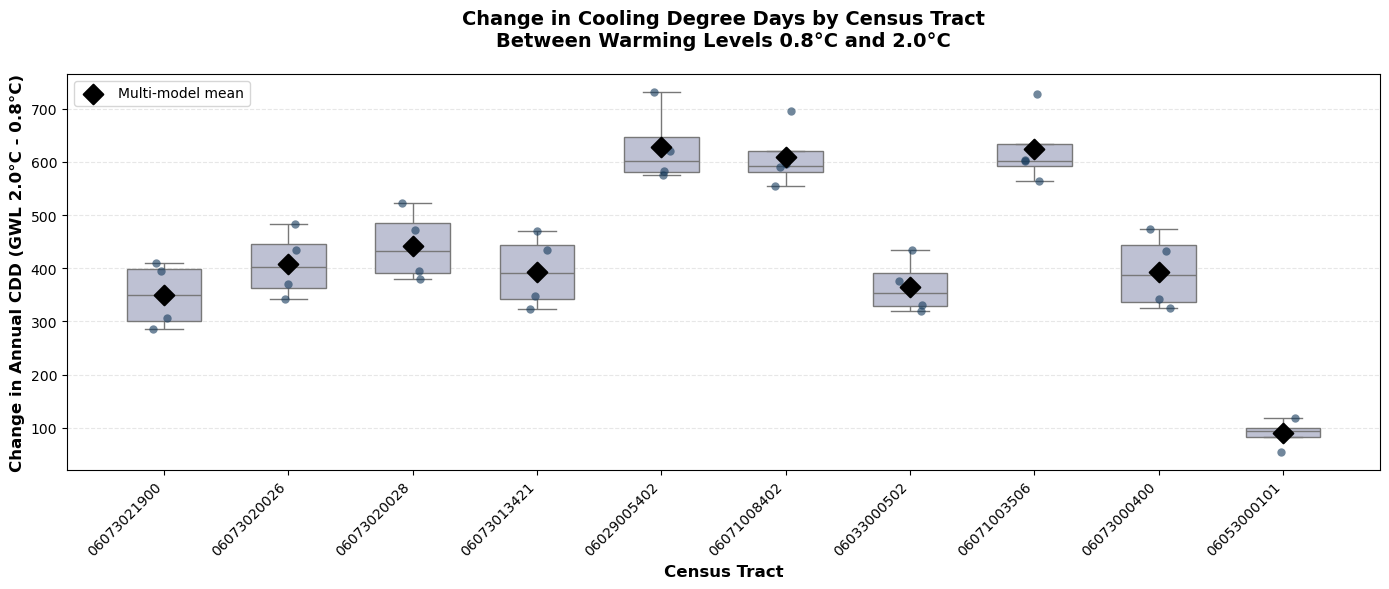


Summary Statistics for CDD Change by Census Tract:
                    mean        std         min         max
census_tract                                               
06029005402   627.679993  72.150002  575.880005  732.000000
06033000502   365.500000  52.509998  318.959991  434.970001
06053000101    89.639999  26.120001   54.689999  118.000000
06071003506   624.219971  70.800003  564.919983  727.039978
06071008402   608.969971  60.160000  554.520020  694.919983
06073000400   393.329987  72.010002  324.329987  474.290009
06073013421   393.730011  69.589996  322.820007  469.500000
06073020026   407.200012  63.270000  341.820007  482.480011
06073020028   442.269989  67.220001  379.980011  523.309998
06073021900   348.910004  62.490002  284.890015  409.760010


In [33]:
import seaborn as sns
import pandas as pd

# Calculate the change (delta) in CDD between warming levels
cdd_change = cdd_annual.sel(warming_level=2.0) - cdd_annual.sel(warming_level=0.8)

# Convert to DataFrame for easier plotting
cdd_change_df = cdd_change.to_dataframe(name='CDD_change').reset_index()

# Calculate multi-model mean for each census tract
cdd_change_mean = cdd_change.mean('sim').to_dataframe(name='CDD_change_mean').reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Create boxplot
sns.boxplot(data=cdd_change_df, x='census_tract', y='CDD_change', 
            color='#BBBFD6', ax=ax, width=0.6, fliersize=0)

# Overlay individual simulation points
sns.stripplot(data=cdd_change_df, x='census_tract', y='CDD_change', 
              color='#13385A', alpha=0.6, size=6, ax=ax, label=None)

# Overlay multi-model mean
ax.scatter(range(len(cdd_change_mean)), cdd_change_mean['CDD_change_mean'], 
           color='black', s=100, marker='D', zorder=5, label='Multi-model mean', 
           edgecolors='black', linewidths=1.5)

# Customize plot
ax.set_xlabel('Census Tract', fontsize=12, fontweight='bold')
ax.set_ylabel('Change in Annual CDD (GWL 2.0°C - 0.8°C)', fontsize=12, fontweight='bold')
ax.set_title('Change in Cooling Degree Days by Census Tract\nBetween Warming Levels 0.8°C and 2.0°C', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for CDD Change by Census Tract:")
print("="*70)
summary = cdd_change_df.groupby('census_tract')['CDD_change'].agg(['mean', 'std', 'min', 'max'])
print(summary.round(2))

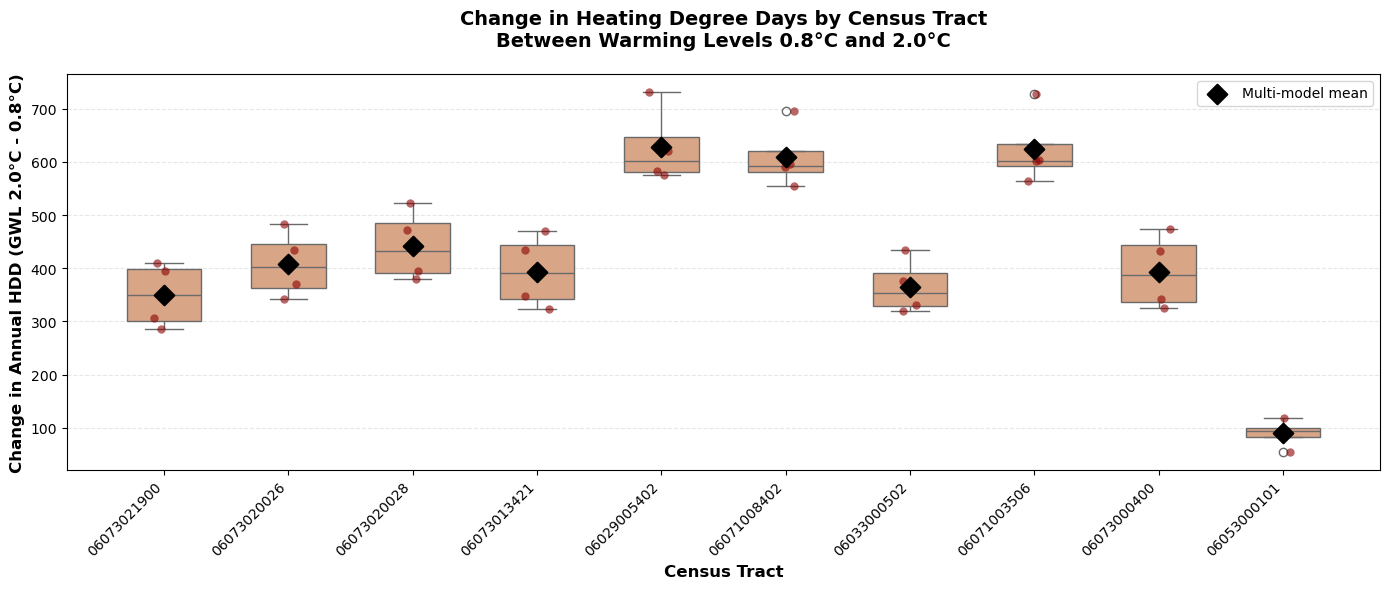


Summary Statistics for HDD Change by Census Tract:
                    mean        std         min         max
census_tract                                               
06029005402   627.679993  72.150002  575.880005  732.000000
06033000502   365.500000  52.509998  318.959991  434.970001
06053000101    89.639999  26.120001   54.689999  118.000000
06071003506   624.219971  70.800003  564.919983  727.039978
06071008402   608.969971  60.160000  554.520020  694.919983
06073000400   393.329987  72.010002  324.329987  474.290009
06073013421   393.730011  69.589996  322.820007  469.500000
06073020026   407.200012  63.270000  341.820007  482.480011
06073020028   442.269989  67.220001  379.980011  523.309998
06073021900   348.910004  62.490002  284.890015  409.760010


In [42]:
# Calculate the change (delta) in HDD between warming levels
hdd_change = hdd_annual.sel(warming_level=2.0) - hdd_annual.sel(warming_level=0.8)

# Convert to DataFrame for easier plotting
hdd_change_df = hdd_change.to_dataframe(name='HDD_change').reset_index()

# Calculate multi-model mean for each census tract
hdd_change_mean = hdd_change.mean('sim').to_dataframe(name='HDD_change_mean').reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Create boxplot
sns.boxplot(data=hdd_change_df, x='census_tract', y='HDD_change', 
            color='#E7A279', ax=ax, width=0.6)

# Overlay individual simulation points
sns.stripplot(data=hdd_change_df, x='census_tract', y='HDD_change', 
              color='darkred', alpha=0.6, size=6, ax=ax, label=None)

# Overlay multi-model mean
ax.scatter(range(len(hdd_change_mean)), hdd_change_mean['HDD_change_mean'], 
           color='black', s=100, marker='D', zorder=5, label='Multi-model mean', 
           edgecolors='black', linewidths=1.5)

# Customize plot
ax.set_xlabel('Census Tract', fontsize=12, fontweight='bold')
ax.set_ylabel('Change in Annual HDD (GWL 2.0°C - 0.8°C)', fontsize=12, fontweight='bold')
ax.set_title('Change in Heating Degree Days by Census Tract\nBetween Warming Levels 0.8°C and 2.0°C', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for HDD Change by Census Tract:")
print("="*70)
summary = hdd_change_df.groupby('census_tract')['HDD_change'].agg(['mean', 'std', 'min', 'max'])
print(summary.round(2))

In [23]:
# calculate annual average total hdd/hdd
hdd_annual = add_dummy_time_to_wl(hdd).squeeze().groupby("time.year").sum(["time"])
hdd_annual = add_dummy_time_to_wl(hdd).squeeze().groupby("time.year").sum(["time"])

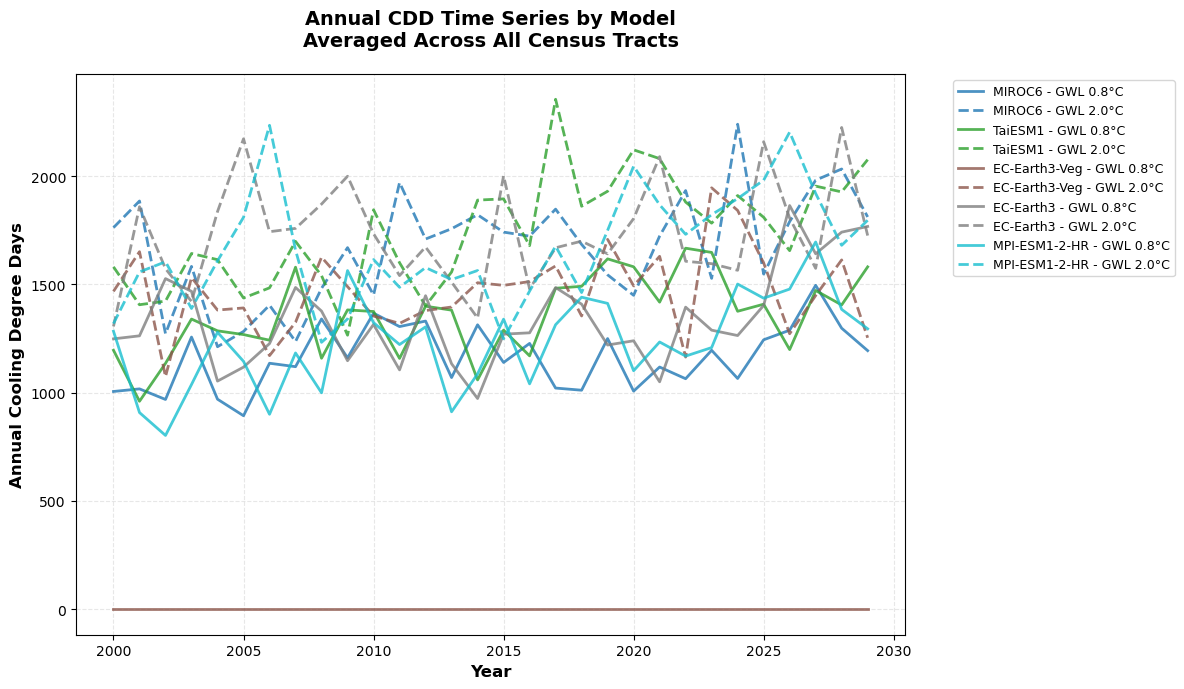

In [24]:
# Create annual CDD time series (without averaging over years)
cdd_annual_ts = add_dummy_time_to_wl(cdd).squeeze().groupby("time.year").sum(["time"])

# Average across all census tracts for cleaner visualization
cdd_annual_ts_avg = cdd_annual_ts.mean('census_tract')

# Create the line plot
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors for each simulation
colors = plt.cm.tab10(np.linspace(0, 1, len(cdd_annual_ts_avg.sim)))

# Plot each simulation for both warming levels
for i, sim in enumerate(cdd_annual_ts_avg.sim.values):
    # Plot GWL 0.8°C (solid line)
    cdd_annual_ts_avg.sel(sim=sim, warming_level=0.8).plot(
        ax=ax, label=f'{sim.split("_")[2]} - GWL 0.8°C', 
        color=colors[i], linestyle='-', linewidth=2, alpha=0.8
    )
    
    # Plot GWL 2.0°C (dashed line)
    cdd_annual_ts_avg.sel(sim=sim, warming_level=2.0).plot(
        ax=ax, label=f'{sim.split("_")[2]} - GWL 2.0°C', 
        color=colors[i], linestyle='--', linewidth=2, alpha=0.8
    )

# Customize plot
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Annual Cooling Degree Days', fontsize=12, fontweight='bold')
ax.set_title('Annual CDD Time Series by Model\nAveraged Across All Census Tracts', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()